# 🧪 Replicating the Mushroom Bandit Experiment: Bayes by Backprop vs ε-greedy (Multi-run, Mean, Log Scale)

In this notebook, we run **two separate experiments**, replicating the setup described in *Blundell et al. (2015)*:
1. **ε-greedy agent** with a deterministic neural network  
2. **Bayes by Backprop agent** with Thompson Sampling (implemented in PyTorch)

---

### 🧠 Environment & Agents

Both agents interact with the **same Mushroom Bandit environment** for **50,000 steps**, but use **independent replay buffers**:
- Each agent stores its own transitions `(context, action, reward)`
- When the buffer reaches the minimum size (`BATCH_SIZE = 64`), each agent samples a minibatch from its own experiences and updates the network.

---

### 🔁 Repetitions & Evaluation

We **repeat the experiment for 5 different random seeds**, compute the **average cumulative regret**, and plot the results on a **logarithmic scale**.

---

### ⚙️ Common Parameters

- **Network architecture**: 2 hidden layers with 100 ReLU units each  
- **Learning rate**: 1 × 10⁻³  
- **Mini-batch size (online training)**: 64  
- **Replay buffer size**: 4096 transitions  
- **Total number of steps**: 50,000  
- **ε for ε-greedy**: [0.0, 0.01, 0.05]

---


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tqdm import trange

# Impostiamo device (GPU se disponibile)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🚀 Usando device: {device}")

🚀 Usando device: cuda


## 📦Loading and Preprocessing of Mushroom UCI Dataset

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = [
    "class", "cap_shape", "cap_surface", "cap_color", "bruises", "odor",
    "gill_attachment", "gill_spacing", "gill_size", "gill_color",
    "stalk_shape", "stalk_root", "stalk_surface_above_ring",
    "stalk_surface_below_ring", "stalk_color_above_ring",
    "stalk_color_below_ring", "veil_type", "veil_color", "ring_number",
    "ring_type", "spore_print_color", "population", "habitat"
]
df = pd.read_csv(url, header=None, names=columns)
df = df[df["stalk_root"] != "?"].reset_index(drop=True)

labels = df["class"].values       # 'e' = edibile, 'p' = velenoso
X_categ = df.drop(columns=["class"]).values  # shape: (N, 22)
enc = OneHotEncoder(sparse_output=False)
X_onehot = enc.fit_transform(X_categ).astype(np.float32)
y_true = (labels == "e").astype(np.int64)

N_SAMPLES, input_dim = X_onehot.shape
print(f"✅ Dataset Mushroom: {N_SAMPLES} esempi, input_dim = {input_dim}")

✅ Dataset Mushroom: 5644 esempi, input_dim = 98


## 📗Reward e Regret functions

In [11]:
def sample_reward(is_edible: int, action: int) -> int:
    if action == 1:
        return 0
    else:
        if is_edible == 1:
            return 5
        else:
            return 5 if (random.random() < 0.5) else -35

def optimal_reward(is_edible: int) -> int:
    return 5 if is_edible == 1 else 0

## 🔧 Networks definition

### 1️⃣ Deterministic Net (for ε-greedy)

In [12]:
class DeterministicNet(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + 2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class EpsilonGreedyAgent:
    def __init__(self, input_dim: int, epsilon: float, lr: float, buffer_size: int, batch_size: int):
        self.epsilon = epsilon
        self.model = DeterministicNet(input_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer_context = np.zeros((buffer_size, input_dim), dtype=np.float32)
        self.buffer_action  = np.zeros((buffer_size, 2), dtype=np.float32)
        self.buffer_reward  = np.zeros((buffer_size, 1), dtype=np.float32)
        self.buffer_index = 0
        self.buffer_count = 0

    def select_action(self, ctx: torch.Tensor, ignore: torch.Tensor) -> int:
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            with torch.no_grad():
                q_eat = self.model(ctx).item()
                q_ignore = self.model(ignore).item()
            return 0 if q_eat > q_ignore else 1

    def add_to_buffer(self, ctx_np: np.ndarray, act_oh: np.ndarray, rew: float):
        idx = self.buffer_index
        self.buffer_context[idx] = ctx_np
        self.buffer_action[idx]  = act_oh
        self.buffer_reward[idx]  = rew
        self.buffer_index = (idx + 1) % self.buffer_size
        self.buffer_count = min(self.buffer_count + 1, self.buffer_size)

    def sample_batch_and_update(self):
        if self.buffer_count < self.batch_size:
            return
        idxs = np.random.choice(self.buffer_count, size=self.batch_size, replace=False)
        ctx_b = self.buffer_context[idxs]
        act_b = self.buffer_action[idxs]
        rew_b = self.buffer_reward[idxs]
        inp_batch = np.concatenate([ctx_b, act_b], axis=1)
        inp_batch_t = torch.from_numpy(inp_batch).to(device)
        target = torch.from_numpy(rew_b).to(device)
        self.optimizer.zero_grad()
        pred = self.model(inp_batch_t)
        loss = F.mse_loss(pred, target)
        loss.backward()
        self.optimizer.step()

### 2️⃣ Bayesian Net (Bayes by Backprop)

In [13]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.mu_weight  = nn.Parameter(torch.zeros(out_features, in_features))
        self.rho_weight = nn.Parameter(torch.ones(out_features, in_features) * -3.0)
        self.mu_bias    = nn.Parameter(torch.zeros(out_features))
        self.rho_bias   = nn.Parameter(torch.ones(out_features) * -3.0)

    def forward(self, x, sample: bool = True):
        sigma_w = torch.log1p(torch.exp(self.rho_weight))
        sigma_b = torch.log1p(torch.exp(self.rho_bias))
        if self.training and sample:
            eps_w = torch.randn_like(self.mu_weight)
            eps_b = torch.randn_like(self.mu_bias)
            w = self.mu_weight + sigma_w * eps_w
            b = self.mu_bias + sigma_b * eps_b
        else:
            w = self.mu_weight
            b = self.mu_bias

        kl_w = self._kl_div(self.mu_weight, sigma_w)
        kl_b = self._kl_div(self.mu_bias.unsqueeze(1), sigma_b.unsqueeze(1))
        self.kl = kl_w + kl_b

        return F.linear(x, w, b)

    def _kl_div(self, mu_q, sigma_q):
        mu_p = torch.zeros_like(mu_q)
        sigma_p = torch.ones_like(sigma_q)
        var_q = sigma_q.pow(2)
        var_p = sigma_p.pow(2)
        term1 = torch.log(sigma_p / sigma_q)
        term2 = (var_q + (mu_q - mu_p).pow(2)) / (2 * var_p)
        kl = term1 + term2 - 0.5
        return kl.sum()

class BayesByBackpropAgent:
    def __init__(self, input_dim: int, lr: float, buffer_size: int, batch_size: int):
        self.model = nn.Sequential(
            BayesianLinear(input_dim + 2, 100),
            nn.ReLU(),
            BayesianLinear(100, 100),
            nn.ReLU(),
            BayesianLinear(100, 1)
        ).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer_context = np.zeros((buffer_size, input_dim), dtype=np.float32)
        self.buffer_action  = np.zeros((buffer_size, 2), dtype=np.float32)
        self.buffer_reward  = np.zeros((buffer_size, 1), dtype=np.float32)
        self.buffer_index = 0
        self.buffer_count = 0

    def select_action(self, ctx: torch.Tensor, ignore: torch.Tensor) -> int:
        # Campioniamo UNA sola volta i pesi
        self.model.train()

        # mettiamo ctx e ignore in un mini‐batch da 2 esempi, così usiamo gli stessi w ~ q(w|θ)
        batch = torch.cat([ctx, ignore], dim=0)       # shape = (2, input_dim+2)

        # forward una volta sola, con sampling interno di BayesianLinear
        qs = self.model(batch)                       # qs[0]: Q(mangi, sampled w), qs[1]: Q(ignora, stesso w)
        q_eat, q_ignore = qs[0].item(), qs[1].item()

        return 0 if q_eat > q_ignore else 1

    def add_to_buffer(self, ctx_np: np.ndarray, act_oh: np.ndarray, rew: float):
        idx = self.buffer_index
        self.buffer_context[idx] = ctx_np
        self.buffer_action[idx]  = act_oh
        self.buffer_reward[idx]  = rew
        self.buffer_index = (idx + 1) % self.buffer_size
        self.buffer_count = min(self.buffer_count + 1, self.buffer_size)

    def sample_batch_and_update(self):
        if self.buffer_count < self.batch_size:
            return
        idxs = np.random.choice(self.buffer_count, size=self.batch_size, replace=False)
        ctx_b = self.buffer_context[idxs]
        act_b = self.buffer_action[idxs]
        rew_b = self.buffer_reward[idxs]
        inp_batch = np.concatenate([ctx_b, act_b], axis=1)
        inp_batch_t = torch.from_numpy(inp_batch).to(device)
        target_b = torch.from_numpy(rew_b).to(device)

        self.optimizer.zero_grad()
        self.model.train()
        out = self.model(inp_batch_t)
        mse_loss = F.mse_loss(out, target_b)
        kl_sum = 0.0
        for module in self.model:
            if isinstance(module, BayesianLinear):
                kl_sum += module.kl
        kl_loss = kl_sum / self.buffer_size
        total_loss = mse_loss + kl_loss
        total_loss.backward()
        self.optimizer.step()

## 🔄 Single Run Function (specific seed)

In [14]:
def run_single_experiment(seed_val: int):
    # Impostiamo tutti i semi
    np.random.seed(seed_val)
    random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)

    # Inizializziamo agenti ε-greedy e Bayesiani
    eg_agents = {eps: EpsilonGreedyAgent(input_dim, eps, LEARNING_RATE, BUFFER_SIZE, BATCH_SIZE)
                 for eps in epsilons}
    bb_agent = BayesByBackpropAgent(input_dim, LEARNING_RATE, BUFFER_SIZE, BATCH_SIZE)

    regret_eps = {eps: np.zeros(STEP_TOTAL, dtype=np.float32) for eps in epsilons}
    regret_bayes = np.zeros(STEP_TOTAL, dtype=np.float32)

    # Barra di avanzamento per i 50k step
    for step in trange(STEP_TOTAL, desc=f"Run seed={seed_val}", leave=False):
        idx = np.random.randint(0, N_SAMPLES)
        ctx = X_onehot[idx, :]
        is_edible = int(y_true[idx])

        arr_eat = np.concatenate([ctx, np.array([1.0, 0.0], dtype=np.float32)], axis=0)
        arr_ignore = np.concatenate([ctx, np.array([0.0, 1.0], dtype=np.float32)], axis=0)
        inp_eat_t = torch.from_numpy(arr_eat[None, :]).to(device)
        inp_ignore_t = torch.from_numpy(arr_ignore[None, :]).to(device)

        for eps, agent in eg_agents.items():
            action = agent.select_action(inp_eat_t, inp_ignore_t)
            rew = sample_reward(is_edible, action)
            regret_eps[eps][step] = optimal_reward(is_edible) - rew
            act_oh = np.array([1.0, 0.0], dtype=np.float32) if action == 0 else np.array([0.0, 1.0], dtype=np.float32)
            agent.add_to_buffer(ctx, act_oh, rew)
            agent.sample_batch_and_update()

        action_b = bb_agent.select_action(inp_eat_t, inp_ignore_t)
        rew_b = sample_reward(is_edible, action_b)
        regret_bayes[step] = optimal_reward(is_edible) - rew_b
        act_b_oh = np.array([1.0, 0.0], dtype=np.float32) if action_b == 0 else np.array([0.0, 1.0], dtype=np.float32)
        bb_agent.add_to_buffer(ctx, act_b_oh, rew_b)
        bb_agent.sample_batch_and_update()

    cumu_eps = {eps: np.cumsum(regret_eps[eps]) for eps in epsilons}
    cumu_bayes = np.cumsum(regret_bayes)
    return cumu_eps, cumu_bayes

## 🔢 Parameters and Seed List

In [15]:
BUFFER_SIZE   = 4096
BATCH_SIZE    = 64
LEARNING_RATE = 1e-3
STEP_TOTAL    = 50000
epsilons = [0.0, 0.01, 0.05]

# Lista di coppie di seed
seed_pairs = [(55, 98), (64, 78), (1234, 69)]  # Puoi modificarla a piacimento

## 🔁 Multiple pairs (optional)


🔁 Pair 1/3 – Seeds: 55, 98


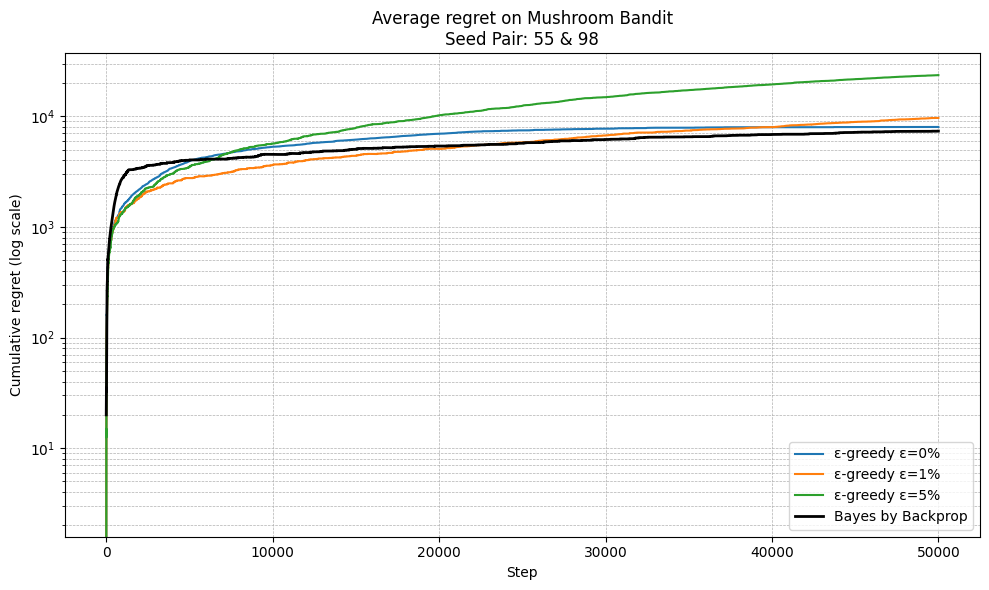


🔁 Pair 2/3 – Seeds: 64, 78


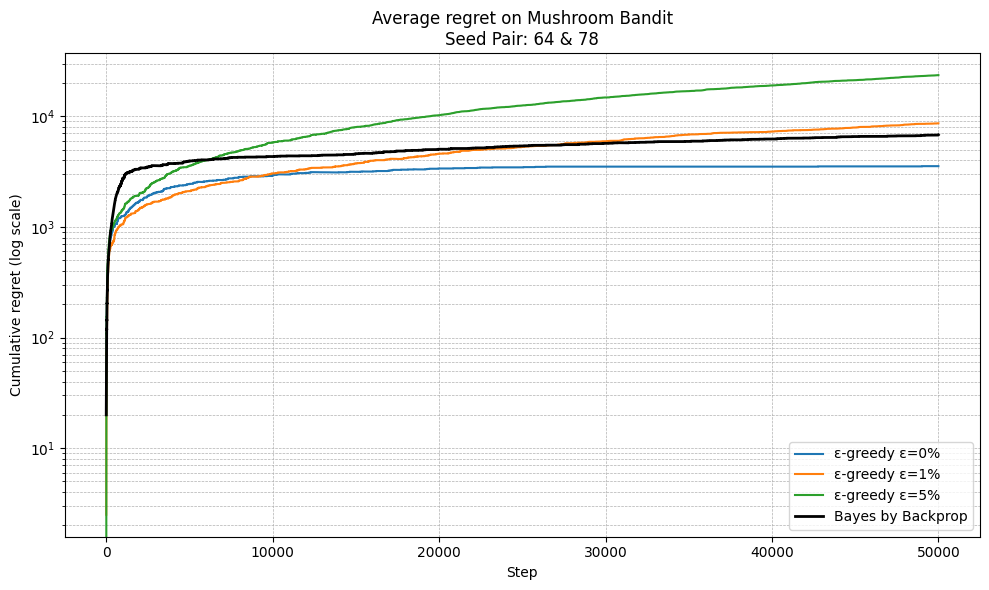


🔁 Pair 3/3 – Seeds: 1234, 69


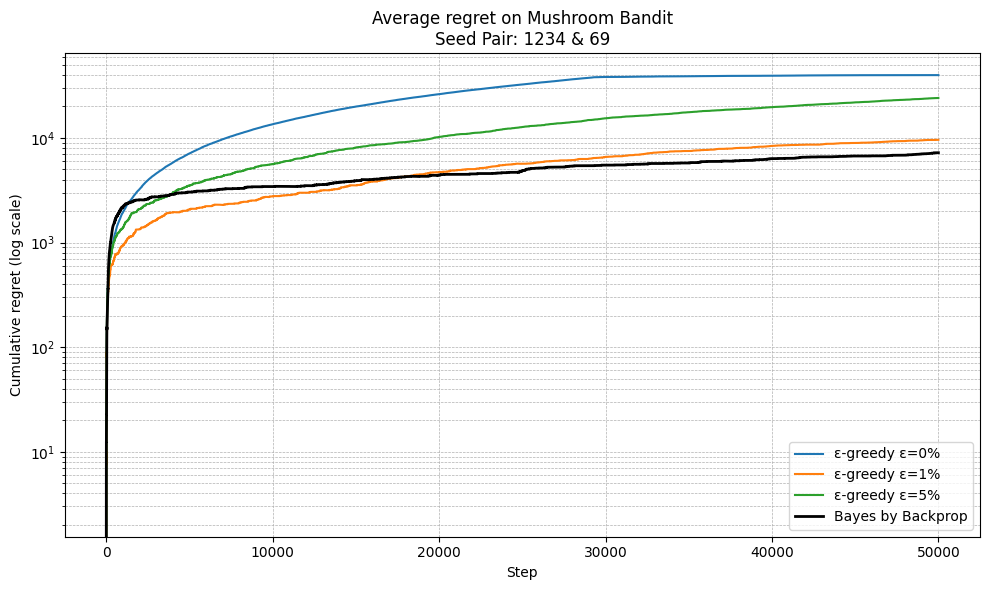


✅ All seed pairs have been processed.


In [16]:
for pair_idx, (seed1, seed2) in enumerate(seed_pairs, start=1):
    print(f"\n🔁 Pair {pair_idx}/{len(seed_pairs)} – Seeds: {seed1}, {seed2}")

    # Save cumulative curves for both runs
    eps_cumu_pair = {eps: [] for eps in epsilons}
    bayes_cumu_pair = []

    for seed_val in (seed1, seed2):
        cumu_eps, cumu_bayes = run_single_experiment(seed_val)
        for eps in epsilons:
            eps_cumu_pair[eps].append(cumu_eps[eps])
        bayes_cumu_pair.append(cumu_bayes)

    # Compute the mean cumulative regret for the seed pair
    mean_cumu_eps = {eps: np.mean(np.stack(eps_cumu_pair[eps], axis=0), axis=0) for eps in epsilons}
    mean_cumu_bayes = np.mean(np.stack(bayes_cumu_pair, axis=0), axis=0)

    # Plot the graph
    plt.figure(figsize=(10, 6))
    for eps in epsilons:
        plt.plot(mean_cumu_eps[eps], label=f"ε-greedy ε={eps*100:.0f}%")
    plt.plot(mean_cumu_bayes, label="Bayes by Backprop", color='black', linewidth=2)
    plt.yscale('log')
    plt.xlabel("Step")
    plt.ylabel("Cumulative regret (log scale)")
    plt.title(f"Average regret on Mushroom Bandit\nSeed Pair: {seed1} & {seed2}")
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()

print("\n✅ All seed pairs have been processed.")
